In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torch.nn import functional as F
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from tqdm import tqdm  # Import tqdm for progress bar
# !pip install py7zr # you need this
# import py7zr
from io import BytesIO ## this too
import os


In [2]:
# Define device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
model = nn.Sequential(
    # Conv2d( in_channels, out_channels, kernel_size) B,3,32,32
    nn.Conv2d(3, 64, 3, stride= 1, padding=1),  nn.BatchNorm2d(64), nn.LeakyReLU(0.1) , nn.MaxPool2d(2, 2), # B,32,16,16
    nn.Conv2d(64, 128, 3, stride= 1, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(0.1), nn.MaxPool2d(2, 2), # B,32,8,8
    nn.Conv2d(128, 256, 3, stride= 1, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(0.1), nn.MaxPool2d(2, 2), # B,32,4,4
    nn.Conv2d(256, 512, 3, stride= 1, padding=1 ), nn.BatchNorm2d(512), nn.LeakyReLU(0.1),
    nn.AdaptiveAvgPool2d(1), ##like in ResNET
    nn.Flatten(),
    nn.Linear(512, 512), nn.BatchNorm1d(512), nn.LeakyReLU(0.1),
    nn.Linear(512, 10)
)

optim = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=0.0005)
scheduler = StepLR(optim, step_size=10, gamma=0.5)

In [4]:
# Define transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.RandomErasing(p=0.5,scale=(0.02, 0.1),value=1.0, inplace=False),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

batch_size=64

In [5]:
## Train with the good old torchvision set

cifar10 = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform_train)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=transform_test)

batch_size = 64 ## increase
n = batch_size
dataloader = DataLoader(cifar10, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_test = DataLoader(cifar10_test, batch_size=batch_size, shuffle=False, num_workers=2) 

Files already downloaded and verified
Files already downloaded and verified


In [6]:
## xavier init
def init_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)  # Apply Xavier normal initialization
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.apply(init_weights_xavier)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): LeakyReLU(negative_slope=0.1)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): LeakyReLU(negative_slope=0.1)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_

In [7]:
i = 0
losses = []
steps = []
losses_t = []

In [8]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

# Initialize variables to track the best loss and patience
best_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement before stopping
patience_counter = 0

for epoch in range(32):
    epoch_loss = 0
    for batch in tqdm(dataloader):
        i += 1
        x = batch[0].to('cuda')
        y = batch[1].to('cuda')
        model = model.to('cuda')

        logits = model(x)
        loss = F.cross_entropy(logits, y)
        optim.zero_grad()

        loss.backward()
        optim.step()

        epoch_loss += loss.item()
        losses.append(loss.item())
        losses_t.append(loss.detach())
        steps.append(i)

        if i % 1000 == 0:
            print(loss)

    # Calculate the average loss for the epoch
    epoch_loss /= len(dataloader)

    # Check if the current epoch loss is better than the best loss
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model_checkpoint.pth')
        print(f"Epoch {epoch + 1}: Improved loss to {best_loss}. Saving model checkpoint.")
    else:
        patience_counter += 1
        print(f"Epoch {epoch + 1}: Loss did not improve. Patience counter at {patience_counter}.")

    # Check if patience has been exceeded
    if patience_counter >= patience:
        print(f"Epoch {epoch + 1}: Loss has not improved for {patience} epochs. Stopping training.")
        break

    scheduler.step()


100%|██████████| 782/782 [00:26<00:00, 29.85it/s]


Epoch 1: Improved loss to 1.4545461267918882. Saving model checkpoint.


 29%|██▉       | 225/782 [00:11<00:17, 32.02it/s]

tensor(1.2267, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:25<00:00, 30.67it/s]


Epoch 2: Improved loss to 1.1540832063731026. Saving model checkpoint.


 57%|█████▋    | 442/782 [00:17<00:08, 40.73it/s]

tensor(1.1456, device='cuda:0', grad_fn=<NllLossBackward0>)


 84%|████████▍ | 659/782 [00:23<00:03, 39.68it/s]

tensor(0.8342, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:27<00:00, 28.56it/s]


Epoch 4: Improved loss to 0.9394427178156041. Saving model checkpoint.


100%|██████████| 782/782 [00:26<00:00, 29.46it/s]


Epoch 3: Improved loss to 1.0276750999948252. Saving model checkpoint.


100%|██████████| 782/782 [00:27<00:00, 28.54it/s]


Epoch 5: Improved loss to 0.878786430029613. Saving model checkpoint.


 12%|█▏        | 95/782 [00:12<00:15, 45.69it/s] 

tensor(0.8706, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:26<00:00, 29.09it/s]


Epoch 6: Improved loss to 0.8328781476639726. Saving model checkpoint.


 40%|████      | 315/782 [00:13<00:09, 49.25it/s]

tensor(1.1115, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:24<00:00, 32.35it/s]


Epoch 7: Improved loss to 0.794901913427331. Saving model checkpoint.


 68%|██████▊   | 531/782 [00:17<00:05, 49.32it/s]

tensor(1.0413, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 34.54it/s]


Epoch 8: Improved loss to 0.7632275067098305. Saving model checkpoint.


 96%|█████████▌| 752/782 [00:21<00:00, 50.71it/s]

tensor(0.9215, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 35.13it/s]


Epoch 9: Improved loss to 0.7353054869281667. Saving model checkpoint.


100%|██████████| 782/782 [00:22<00:00, 35.24it/s]


Epoch 10: Improved loss to 0.713337823786699. Saving model checkpoint.


 24%|██▎       | 185/782 [00:10<00:13, 45.06it/s]

tensor(0.7976, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:24<00:00, 31.47it/s]


Epoch 11: Improved loss to 0.6254211406192511. Saving model checkpoint.


 52%|█████▏    | 405/782 [00:15<00:07, 50.91it/s]

tensor(0.5156, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:23<00:00, 32.77it/s]


Epoch 12: Improved loss to 0.6032663841000603. Saving model checkpoint.


 79%|███████▉  | 619/782 [00:19<00:03, 50.73it/s]

tensor(0.5385, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:23<00:00, 33.35it/s]


Epoch 13: Improved loss to 0.5931512111288202. Saving model checkpoint.


100%|██████████| 782/782 [00:24<00:00, 31.70it/s]


Epoch 14: Improved loss to 0.5740850150508954. Saving model checkpoint.


  7%|▋         | 56/782 [00:08<00:22, 32.47it/s] 

tensor(0.7359, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:23<00:00, 32.65it/s]


Epoch 15: Improved loss to 0.5662208212458569. Saving model checkpoint.


 35%|███▌      | 276/782 [00:12<00:10, 50.37it/s]

tensor(0.5975, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 34.41it/s]


Epoch 16: Improved loss to 0.5561913684048616. Saving model checkpoint.


 63%|██████▎   | 494/782 [00:17<00:05, 48.04it/s]

tensor(0.6672, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:23<00:00, 32.86it/s]


Epoch 17: Improved loss to 0.5496999099660103. Saving model checkpoint.


 91%|█████████▏| 714/782 [00:20<00:01, 50.26it/s]

tensor(0.6734, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 34.37it/s]


Epoch 18: Improved loss to 0.5417533831675644. Saving model checkpoint.


100%|██████████| 782/782 [00:22<00:00, 35.41it/s]


Epoch 19: Improved loss to 0.5285031745958206. Saving model checkpoint.


 19%|█▉        | 151/782 [00:09<00:12, 51.30it/s]

tensor(0.4961, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:21<00:00, 35.65it/s]


Epoch 20: Improved loss to 0.5217245589284336. Saving model checkpoint.


 46%|████▋     | 363/782 [00:13<00:08, 51.44it/s]

tensor(0.3318, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 35.02it/s]


Epoch 21: Improved loss to 0.4728846221095156. Saving model checkpoint.


 75%|███████▍  | 586/782 [00:17<00:03, 49.51it/s]

tensor(0.4495, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 35.47it/s]


Epoch 22: Improved loss to 0.4532283574266507. Saving model checkpoint.


100%|██████████| 782/782 [00:22<00:00, 35.11it/s]


Epoch 23: Improved loss to 0.4517119226172147. Saving model checkpoint.


  2%|▏         | 18/782 [00:06<01:54,  6.69it/s] 

tensor(0.4866, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 35.24it/s]


Epoch 24: Improved loss to 0.444150087130649. Saving model checkpoint.


 31%|███       | 240/782 [00:11<00:10, 51.71it/s]

tensor(0.4134, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 35.21it/s]


Epoch 25: Improved loss to 0.4372571224484907. Saving model checkpoint.


 58%|█████▊    | 457/782 [00:15<00:06, 50.48it/s]

tensor(0.3915, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 35.03it/s]


Epoch 26: Improved loss to 0.43261676687566214. Saving model checkpoint.


 86%|████████▋ | 675/782 [00:20<00:02, 46.73it/s]

tensor(0.4558, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:23<00:00, 34.00it/s]


Epoch 27: Improved loss to 0.4222554991312344. Saving model checkpoint.


100%|██████████| 782/782 [00:23<00:00, 33.46it/s]


Epoch 28: Improved loss to 0.4182611697584467. Saving model checkpoint.


 14%|█▍        | 111/782 [00:08<00:13, 48.97it/s]

tensor(0.5793, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 34.47it/s]


Epoch 29: Improved loss to 0.417812861349729. Saving model checkpoint.


 42%|████▏     | 329/782 [00:13<00:09, 47.59it/s]

tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 34.52it/s]


Epoch 30: Improved loss to 0.4122428425475764. Saving model checkpoint.


 70%|███████   | 548/782 [00:18<00:04, 49.88it/s]

tensor(0.4715, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:23<00:00, 33.31it/s]


Epoch 31: Improved loss to 0.38301587813650556. Saving model checkpoint.


 98%|█████████▊| 763/782 [00:21<00:00, 49.46it/s]

tensor(0.4537, device='cuda:0', grad_fn=<NllLossBackward0>)


100%|██████████| 782/782 [00:22<00:00, 34.16it/s]

Epoch 32: Improved loss to 0.37620318595253294. Saving model checkpoint.


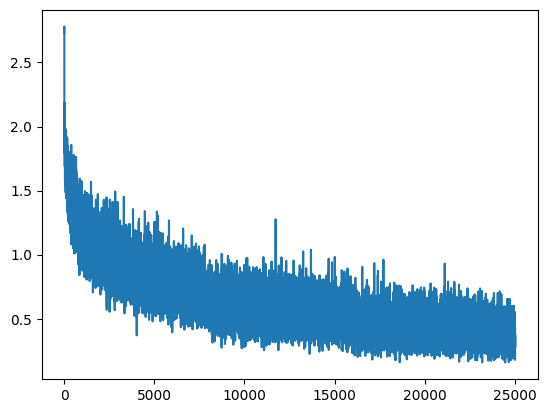

In [13]:
plt.plot(steps, losses)

In [14]:
total_correct = 0
total_predictions = 0

# Loop over training dataset
for x_batch, y_batch in dataloader:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy
overall_accuracy = total_correct / total_predictions
print(f"Training Accuracy: {overall_accuracy}")

Training Accuracy: 0.87256


In [15]:
total_correct = 0
total_predictions = 0

# Loop over testing dataset
for x_batch, y_batch in dataloader_test:
    logits = model(x_batch.to("cuda")) # Forward pass on the mini-batch
    loss = F.cross_entropy(logits.cpu(), y_batch) # Compute loss

    # Calculate predictions for the batch
    pred_labels = torch.max(logits, dim=1).indices

    # Update total correct predictions and total predictions
    total_correct += (y_batch == pred_labels.cpu()).sum().item()
    total_predictions += y_batch.size(0)

# Calculate overall accuracy and print it out.
overall_accuracy = total_correct / total_predictions
#DON'T FORGET TO PRINT OUT YOUR TESTING ACCURACY
print(f"Testing Accuracy: {overall_accuracy}")

Testing Accuracy: 0.8611


In [12]:
# # Create submission file with predictions for test images from .7z archive
# test_filenames = []
# test_images = []
# 
# with py7zr.SevenZipFile('/kaggle/input/cifar-10/test.7z', mode='r') as z:
#     for name, file in z.readall().items():
#         if name.endswith('.png'):
#             img = Image.open(BytesIO(file.read()))
#             test_images.append(transform_test(img))
#             test_filenames.append(name)
# 
# test_images = torch.stack(test_images)
# test_loader = DataLoader(test_images, batch_size=batch_size, shuffle=False)
# 
# # Prediction and CSV creation
# classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# 
# result = []
# with torch.no_grad():
#     model.eval()
#     for inputs in tqdm(test_loader):
#         inputs = inputs.to(device)
#         outputs = model(inputs)
#         _, predicted = outputs.max(1)
#         result.extend(predicted.cpu().numpy())
# 
# # Create submission DataFrame
# submission_df = pd.DataFrame({
#     'id': [os.path.basename(f).replace('.png', '') for f in test_filenames],  # Remove .png from filenames
#     'label': [classes[label] for label in result]
# })
# 
# # Save submission file
# submission_df.to_csv('/kaggle/working/submission.csv', index=False)
# 
# print("Submission file created successfully!")